<a href="https://colab.research.google.com/github/DerekYee22/AP-CS/blob/main/NBA_game_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NBA game predictor with sklearn

In [ ]:
!pip install nba_api

import pandas as pd
import numpy as np
import time
from nba_api.stats.endpoints import leaguegamelog, boxscoretraditionalv2, BoxScoreAdvancedV3
from nba_api.stats.library.parameters import Season, SeasonType
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.0/319.0 kB 5.2 MB/s eta 0:00:00


## Which features are the best indicators for winning a individual game?

### Load games

In [ ]:
gamelog = leaguegamelog.LeagueGameLog(
                season='2024-25',
                season_type_all_star=SeasonType.regular
            )

all_games = gamelog.get_data_frames()[0]

all_team_stats = pd.DataFrame()

for game_id in all_games['GAME_ID'][:100]:
    try:
        boxscore = BoxScoreAdvancedV3(game_id=game_id)
        dfs = boxscore.get_data_frames()

        all_advanced_team_stats = dfs[1].rename(columns={'gameId': 'GAME_ID', 'teamId': 'TEAM_ID'})
        all_team_stats = pd.concat([all_team_stats, all_advanced_team_stats], ignore_index=True)

        time.sleep(0.4)
    except Exception as e:
        print(f"Error fetching {game_id}: {e}")

all_team_stats = all_team_stats.merge(all_games, on=['GAME_ID', 'TEAM_ID'], how='left')

all_team_stats = all_team_stats.drop(columns=['GAME_ID', 'teamCity', 'teamTricode', 'teamSlug','SEASON_ID', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'MATCHUP', 'MIN', 'VIDEO_AVAILABLE'])

all_team_stats.to_csv('all_team_stats.csv', index=False)

### Graph Results

/tmp/ipython-input-550830286.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=abs(top_scaled_features.values), y=top_scaled_features.index, palette='coolwarm_r')


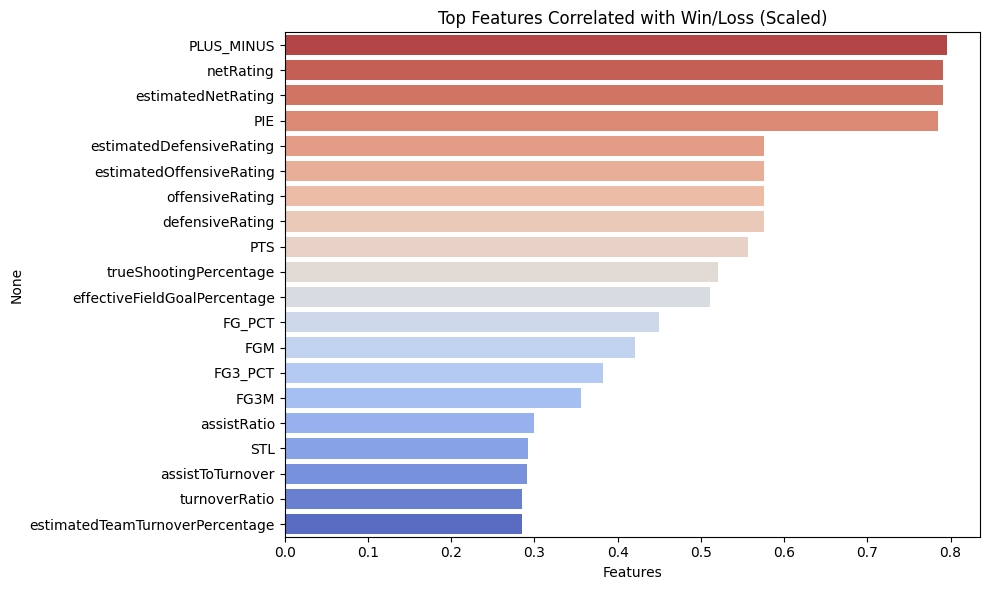

In [ ]:
all_team_stats['WL_binary'] = all_team_stats['WL'].map({'W': 1, 'L': 0})

features = all_team_stats.select_dtypes(include='number')

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df['WL_binary'] = all_team_stats['WL_binary'].values
scaled_corr = scaled_df.corr()['WL_binary'].drop('WL_binary').sort_values(key=abs, ascending=False)
top_scaled_features = scaled_corr.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=abs(top_scaled_features.values), y=top_scaled_features.index, palette='coolwarm_r')
plt.title("Top Features Correlated with Win/Loss (Scaled)")
plt.xlabel("Correlation with WL")
plt.xlabel("Features")

plt.tight_layout()
plt.show()

##Predictive Model based on last 20 games of each team

### Data Loading

In [ ]:
random_games = all_games.sample(n=1000, random_state=41)

from nba_api.stats.static import teams

nba_teams = teams.get_teams()

def get_team_id(team_name):
    for team in nba_teams:
        if team['abbreviation'] == team_name:
          return team['id']

games = []

for i in range(len(random_games)):
    home_team = random_games.iloc[i]['MATCHUP'].split(' ')[0]
    away_team = random_games.iloc[i]['MATCHUP'].split(' ')[2]

    games.append({
        'home_id': get_team_id(home_team),
        'away_id': get_team_id(away_team),
        'game_date': pd.to_datetime(random_games.iloc[i]['GAME_DATE']).strftime('%Y-%m-%d')
    })

In [ ]:
def get_stats(team_id, game_date, num_of_games=21, gamelog=all_games):
    game_date = datetime.strptime(game_date, "%Y-%m-%d")
    gamelog['GAME_DATE'] = pd.to_datetime(gamelog['GAME_DATE'])

    team_games = gamelog[
        (gamelog['GAME_DATE'] < game_date) & (gamelog['TEAM_ID'] == team_id)
    ].sort_values('GAME_DATE', ascending=False).head(num_of_games).copy()

    result_rows = []

    for _, team_row in team_games.iterrows():
        game_id = team_row['GAME_ID']

        opponent_row = gamelog[
            (gamelog['GAME_ID'] == game_id) & (gamelog['TEAM_ID'] != team_id)
        ]

        if opponent_row.empty:
            continue  # skip game

        opponent_row = opponent_row.iloc[0]

        combined = {}
        for col in team_row.index:
            combined[f'TEAM_{col}'] = team_row[col]
        for col in opponent_row.index:
            combined[f'OPP_{col}'] = opponent_row[col]

        result_rows.append(combined)

    if not result_rows:
        return pd.DataFrame()

    cleaned_stats_df = pd.DataFrame(result_rows).drop(columns=[
        'TEAM_SEASON_ID', 'TEAM_TEAM_ID', 'TEAM_TEAM_ABBREVIATION',
        'TEAM_TEAM_NAME', 'TEAM_GAME_ID', 'TEAM_MATCHUP', 'TEAM_VIDEO_AVAILABLE',
        'OPP_SEASON_ID', 'OPP_TEAM_ID', 'OPP_TEAM_ABBREVIATION', 'OPP_TEAM_NAME',
        'OPP_GAME_ID', 'OPP_GAME_DATE', 'OPP_MATCHUP', 'OPP_VIDEO_AVAILABLE',
        'TEAM_MIN', 'OPP_WL', 'OPP_MIN', 'OPP_PLUS_MINUS', 'TEAM_GAME_DATE'
    ])

    if 'TEAM_WL' in cleaned_stats_df.columns:
        cleaned_stats_df['TEAM_WL_binary'] = cleaned_stats_df['TEAM_WL'].map({'W': 1, 'L': 0})
        cleaned_stats_df = cleaned_stats_df.drop(columns=['TEAM_WL'])
    else:
        cleaned_stats_df['TEAM_WL_binary'] = np.nan

    # Build difference stats
    diff_stats = pd.DataFrame()
    for col in cleaned_stats_df.columns:
        if col.startswith('TEAM_') and cleaned_stats_df[col].dtype in ['int64', 'float64']:
            opp_col = col.replace('TEAM_', 'OPP_')
            if opp_col in cleaned_stats_df.columns:
                diff_stats[f'diff_{col[5:]}'] = cleaned_stats_df[col] - cleaned_stats_df[opp_col]

    final_stats = pd.concat([cleaned_stats_df.reset_index(drop=True), diff_stats.reset_index(drop=True)], axis=1)
    final_stats["NUM_OF_GAMES"] = len(team_games)

    return final_stats


In [ ]:
def exponential_weighted_average(stats, decay_factor=0.98):
    # Weights with exponential decay
    weights = [decay_factor ** i for i in range(len(stats))]

    # Calculate weighted average
    weighted_sum = sum(float(stat) * weight for stat, weight in zip(stats, weights))
    total_weight = sum(weights)

    if total_weight == 0:
        return 0

    return weighted_sum / total_weight


def weight_stats(stats):
    if stats.empty:
        print("No stats available")
        return pd.DataFrame()

    past_stats = stats.iloc[1:].reset_index(drop=True)

    if past_stats.empty:
        print("Not enough past games for weighted average")
        return pd.DataFrame()

    weighted_df = pd.DataFrame()
    weighted_values = {}

    for stat in past_stats.columns:
        if stat == 'NUM_OF_GAMES' or stat == 'TEAM_GAME_DATE':
            weighted_values[stat] = past_stats[stat].iloc[0]
        else:
            weighted_avg = exponential_weighted_average(past_stats[stat], decay_factor=0.98)
            weighted_values[stat] = weighted_avg

    weighted_df = pd.DataFrame([weighted_values])

    weighted_df['WL_result'] = stats.iloc[0]['TEAM_WL_binary']

    return weighted_df

In [ ]:
def combine_stats(home, away):
    combined = pd.concat([home.add_prefix('home_'), away.add_prefix('away_')], axis=1)

    return combined

all_game_stats = []

for i in range(len(games)):
    home_stats = get_stats(games[i]['home_id'], games[i]['game_date'])
    away_stats = get_stats(games[i]['away_id'], games[i]['game_date'])

    if home_stats.empty or away_stats.empty:
        continue

    home = weight_stats(home_stats)
    away = weight_stats(away_stats)

    if home.empty or away.empty:
        continue

    if int(home['NUM_OF_GAMES'][0]) < 5 or int(away['NUM_OF_GAMES'][0]) < 5:
        print(f"Game {i}: Not enough games played")
        continue

    combined = combine_stats(home, away)

    all_game_stats.append(combined)

    time.sleep(0.2)

final_df = pd.concat(all_game_stats, ignore_index=True)

Game 12: Not enough games played
Not enough past games for weighted average
Game 41: Not enough games played
Game 79: Not enough games played
Game 94: Not enough games played
Game 102: Not enough games played
Not enough past games for weighted average
Not enough past games for weighted average
Game 127: Not enough games played
Not enough past games for weighted average
Not enough past games for weighted average
Game 136: Not enough games played
Game 164: Not enough games played
Game 199: Not enough games played
Game 209: Not enough games played
Game 210: Not enough games played
Game 211: Not enough games played
Game 268: Not enough games played
Not enough past games for weighted average
Game 329: Not enough games played
Game 356: Not enough games played
Game 369: Not enough games played
Not enough past games for weighted average
Not enough past games for weighted average
Game 388: Not enough games played
Game 390: Not enough games played
Game 479: Not enough games played
Not enough pas

In [ ]:
final_df.to_csv('final_df_7_26_25.csv', index=False)

final_df

### Data Visualization

In [ ]:
final_df = pd.read_csv('final_df_7_26_25.csv')

In [ ]:
features = final_df.select_dtypes(include='number')

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df['home_WL_result'] = final_df['home_WL_result'].values
scaled_corr = scaled_df.corr()['home_WL_result'].drop('home_WL_result').sort_values(key=abs, ascending=False)
top_scaled_features = scaled_corr.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=abs(top_scaled_features.values), y=top_scaled_features.index, palette='coolwarm_r')
plt.title("Top Features Correlated with Win/Loss (Scaled)")
plt.xlabel("Correlation with WL")
plt.ylabel("Feature Label")

plt.tight_layout()
plt.show()

print(top_scaled_features)

In [ ]:
df = pd.read_csv('final_df_7_26_25.csv')

print(df.info())
print(df.describe())

# Only use # features
non_features = ['GAME_ID', 'TEAM_NAME', 'OPP_TEAM_NAME', 'DATE', 'SEASON', 'TEAM_ID', 'OPP_TEAM_ID']
feature_cols = [col for col in df.columns if col not in non_features]

# You can also filter numeric columns only
numeric_df = df[feature_cols].select_dtypes(include='number')

# Histogram
numeric_df.hist(bins=20, figsize=(18, 12), edgecolor='black')
plt.suptitle("Distribution of Features", fontsize=16)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(18, 8))
sns.boxplot(data=numeric_df)
plt.xticks(rotation=90)
plt.title("Boxplot of Numerical Features")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('final_df_7_26_25.csv')

y = df['home_WL_result']

all_numeric = df.select_dtypes(include='number').drop(columns=['home_WL_result', 'away_WL_result'])

print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Total features available: {len(all_numeric.columns)}")

home_features = [col for col in all_numeric.columns if col.startswith('home_') and 'diff_' not in col]
away_features = [col for col in all_numeric.columns if col.startswith('away_') and 'diff_' not in col]
diff_features = [col for col in all_numeric.columns if 'diff_' in col or col.endswith('_diff')]

feature_sets = {
    'All Features': all_numeric.columns,
    'Diff Features Only': diff_features,
    'Home Features Only': home_features,
    'Away Features Only': away_features,
    'Home + Away': home_features + away_features,
    'Top Statistical': ['home_TEAM_PTS', 'away_TEAM_PTS', 'home_diff_PTS', 'away_diff_PTS',
                       'home_TEAM_FG_PCT', 'away_TEAM_FG_PCT', 'home_TEAM_PLUS_MINUS', 'away_TEAM_PLUS_MINUS']
}

# Model configurations
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=2000, random_state=42),
        'params': {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [3, 5, 7]
        }
    }
}

# Cross-validation

# splits up data set
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
best_models = {}

for feature_name, feature_list in feature_sets.items():
    print(f"\n{'='*20} {feature_name} ({len(feature_list)} features) {'='*20}")

    X = df[feature_list]

    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    feature_set_results = {}

    for model_name, model_config in models.items():
        try:
            if model_name == 'Random Forest' or model_name == 'Gradient Boosting':
                pipeline = Pipeline([
                    # chooses up to 50 of the "most important" features
                    ('feature_selection', SelectKBest(f_classif, k=min(50, len(feature_list)))),
                    # selects model configured above
                    ('classifier', model_config['model'])
                ])

                # loops through testing various model params set in model config
                param_grid = {}
                for key, value in model_config['params'].items():
                    param_grid[f'classifier__{key}'] = value
                param_grid['feature_selection__k'] = [min(20, len(feature_list)), min(30, len(feature_list)), min(50, len(feature_list))]

            # for non-tree models (Logistic Regression)
            else:
                pipeline = Pipeline([
                    ('scaler', RobustScaler()),
                    ('feature_selection', SelectKBest(f_classif, k=min(50, len(feature_list)))),
                    ('classifier', model_config['model'])
                ])

                param_grid = {}
                for key, value in model_config['params'].items():
                    param_grid[f'classifier__{key}'] = value
                param_grid['feature_selection__k'] = [min(20, len(feature_list)), min(30, len(feature_list)), min(50, len(feature_list))]

            # Grid search with cross validation
            grid_search = GridSearchCV(
                pipeline,
                param_grid,
                cv=cv_strategy,
                scoring='accuracy',
                n_jobs=-1,
                verbose=0
            )

            grid_search.fit(X_train, y_train)

            # Get best model
            best_model = grid_search.best_estimator_

            y_pred_train = best_model.predict(X_train)
            y_pred_test = best_model.predict(X_test)

            train_accuracy = accuracy_score(y_train, y_pred_train)
            test_accuracy = accuracy_score(y_test, y_pred_test)
            cv_scores = cross_val_score(best_model, X, y, cv=cv_strategy, scoring='accuracy')

            result = {
                'Feature Set': feature_name,
                'Model': model_name,
                'Train Accuracy': train_accuracy,
                'Test Accuracy': test_accuracy,
                'CV Mean': cv_scores.mean(),
                'CV Std': cv_scores.std(),
                'Best Params': grid_search.best_params_,
                'Features Used': len(feature_list)
            }
            results.append(result)
            feature_set_results[model_name] = test_accuracy

            model_key = f"{feature_name}_{model_name}"
            best_models[model_key] = {
                'model': best_model,
                'accuracy': test_accuracy,
                'feature_list': feature_list
            }

            print(f"* {model_name}:")
            print(f"   Train: {train_accuracy:.4f} | Test: {test_accuracy:.4f} | CV: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
            print(f"   Best params: {grid_search.best_params_}")

        except Exception as e:
            print(f"Error with {model_name}: {str(e)}")

    # Show feature set summary
    if feature_set_results:
        best_model_for_set = max(feature_set_results, key=feature_set_results.get)

# Find top 3 models
results_df = pd.DataFrame(results)
top_models = results_df.nlargest(3, 'Test Accuracy')

print("Top 3 Individual Models:")
for idx, row in top_models.iterrows():
    print(f"{row['Model']} ({row['Feature Set']}): {row['Test Accuracy']:.4f}")

# Create ensemble with best feature set
best_feature_set = top_models.iloc[0]['Feature Set']
X_ensemble = df[feature_sets[best_feature_set]]
X_ensemble = X_ensemble.replace([np.inf, -np.inf], np.nan).fillna(X_ensemble.median())

X_train_ens, X_test_ens, y_train_ens, y_test_ens = train_test_split(
    X_ensemble, y, test_size=0.25, random_state=42, stratify=y
)

# Scale for ensemble
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_ens)
X_test_scaled = scaler.transform(X_test_ens)

# Create voting ensemble
ensemble_models = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, class_weight='balanced')),
    ('gb', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42))
]

voting_clf = VotingClassifier(estimators=ensemble_models, voting='soft')
voting_clf.fit(X_train_scaled, y_train_ens)

# Ensemble predictions
y_pred_ensemble = voting_clf.predict(X_test_scaled)
ensemble_accuracy = accuracy_score(y_test_ens, y_pred_ensemble)

print(f"\nEnsemble Model Accuracy: {ensemble_accuracy:.4f}")

# Feature importance analysis (using Random Forest from ensemble)

rf_model = ensemble_models[0][1]
rf_model.fit(X_train_ens, y_train_ens)
feature_importance = pd.Series(rf_model.feature_importances_, index=feature_sets[best_feature_set]).sort_values(ascending=False)

print(f"Top 15 Most Important Features ({best_feature_set}):")
for i, (feature, importance) in enumerate(feature_importance.head(15).items(), 1):
    print(f"{i:2d}. {feature:<35} {importance:.4f}")

# Final summary
print("FINAL SUMMARY \n")

print(f"Best Individual Model: {top_models.iloc[0]['Model']} with {top_models.iloc[0]['Feature Set']}")
print(f"Best Individual Accuracy: {top_models.iloc[0]['Test Accuracy']:.4f}")
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
print(f"Dataset: {df.shape[0]} games, {len(all_numeric.columns)} features")

# Save results
results_df.to_csv('model_comparison_results.csv', index=False)
print(f"\nResults saved to 'model_comparison_results.csv'")